In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data

from scripts.wandb_utils.zip_handler import ModelSizeZipHandler
from scripts.core.preprocess import truncate
from rliable import plot_utils as rliable_plot_utils

import qscaled

qscaled.constants.QSCALED_PATH = os.path.expanduser('~/.value-scaling')
qscaled.constants.suppress_overwrite_prompt = True

In [4]:
ModelSizeSweepConfig = BaseConfig


config_input_dict = dict(
    max_returns={},
    returns_key='return',
    thresholds=[],  # placeholder
)

config = ModelSizeSweepConfig(
    name='side_critic',  # Zip filename
    wandb_collector=None,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

end_step_for_avg = truncate_steps = 800000
start_step_for_avg = 0.9 * end_step_for_avg

In [5]:
# Fetch the data
df = fetch_zip_data(config, use_cached=True)
df = truncate(df, truncate_steps)
envs = sorted(df['env_name'].unique())

### Full learning curves for the side critic experiments

In [6]:
from rliable import plot_utils

COLORS = [
    '#BBCC33',
    '#77AADD',
    '#44BB99',
    '#EEDD88',
    '#EE8866',
    '#FFAABB',
    '#99DDFF',
    '#44BB99',
    '#AAAA00',
    '#DDDDDD',
]
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{sansmath} \sansmath'  # Force sans-serif math mode (for axes labels)
)
plt.rcParams['font.family'] = 'sans-serif'  # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue']  # Choose a nice font here
sns.set_style('whitegrid')

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
n_colors = 3
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

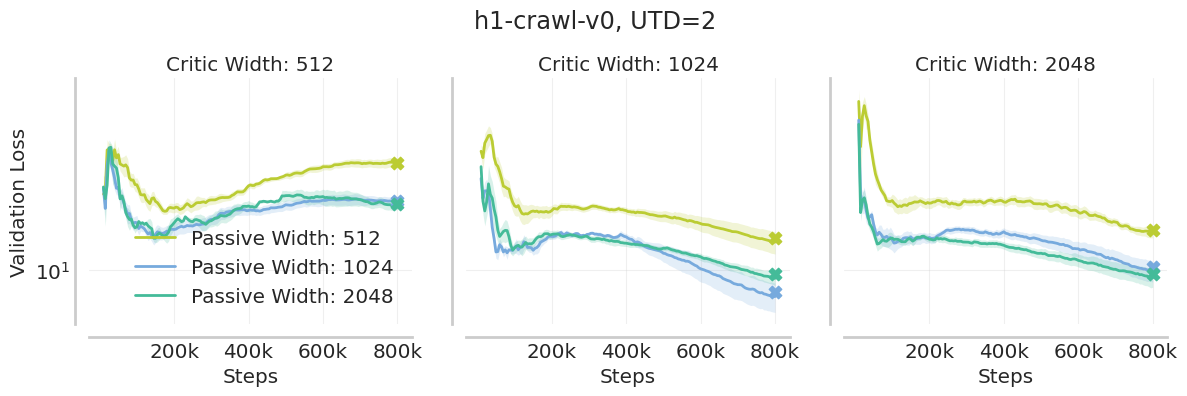

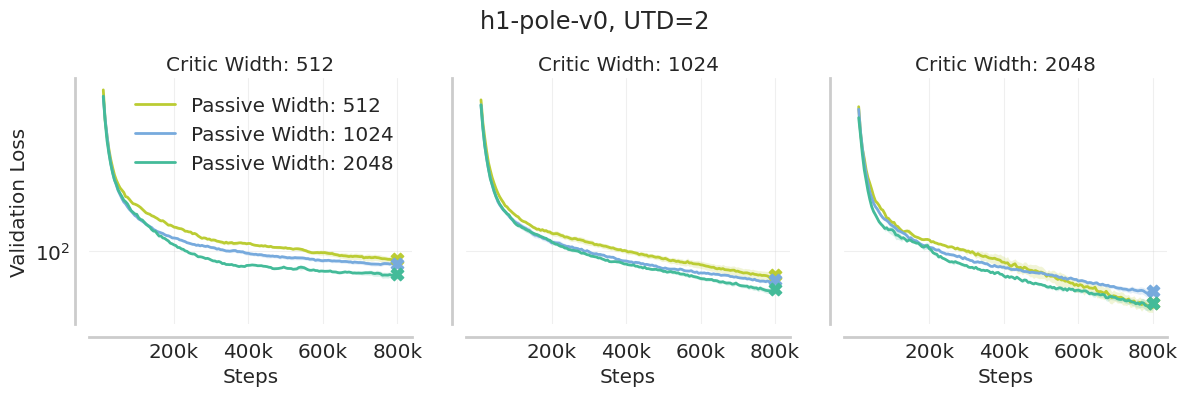

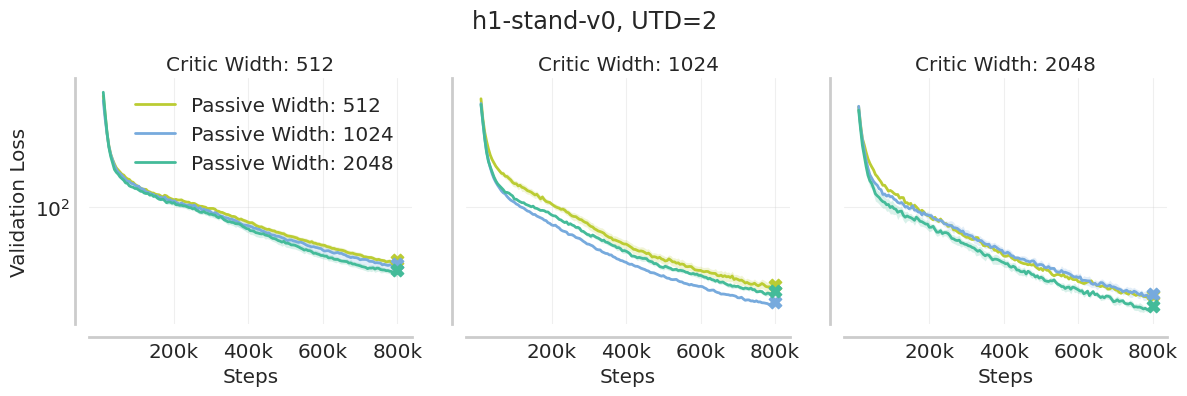

In [7]:
def get_full_learning_curve_data(og_df: pd.DataFrame) -> pd.DataFrame:
    """
    Return raw validation loss time series (as originally logged) alongside training step
    and identifying columns.
    """
    df = og_df.copy()

    train_metric_col_name = 'mean_separate_critic_loss'
    val_metric_col_name = 'mean_sep_validation_critic_loss'
    step_col = 'training_step'

    required_cols = [
        'env_name',
        'critic_width',
        'separate_critic_width',
        step_col,
        val_metric_col_name,
        train_metric_col_name,
        'std_separate_critic_loss',
        'std_sep_validation_critic_loss',
    ]

    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        raise KeyError(f'Missing required columns: {missing_cols}')

    # Coerce numeric types where appropriate
    for col in ['critic_width', 'separate_critic_width']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort for convenience
    df = df.sort_values(['env_name', 'critic_width', 'separate_critic_width']).reset_index(
        drop=True
    )

    return df[required_cols]


# Plotting
for i, ENV in enumerate(envs):
    fig, all_axes = plt.subplots(1, 3, figsize=(12, 4), sharey='row')

    axes = all_axes
    env_df = df.query(f'env_name == "{ENV}"')
    data = get_full_learning_curve_data(env_df)

    all_critic_widths = sorted(data['critic_width'].unique())
    all_separate_critic_widths = sorted(data['separate_critic_width'].unique())
    start_step = 10000

    colors = [COLORS[0], COLORS[1], COLORS[2]]

    for idx, critic_width in enumerate(all_critic_widths):
        ax = axes[idx]
        for jdx, separate_critic_width in enumerate(all_separate_critic_widths):
            subset = data.query(
                f'critic_width == {critic_width} and separate_critic_width == {separate_critic_width}'
            )

            if not subset.empty:
                # Get the actual loss curves
                training_curve = subset['mean_separate_critic_loss'].iloc[0]
                training_curve_std = subset['std_separate_critic_loss'].iloc[0]
                validation_curve = subset['mean_sep_validation_critic_loss'].iloc[0]
                validation_curve_std = subset['std_sep_validation_critic_loss'].iloc[0]

                steps = subset['training_step'].iloc[0]
                step_idx = steps >= start_step
                avg_idx = (steps >= start_step_for_avg) & (steps <= end_step_for_avg)

                # Plot validation loss
                color = colors[jdx]
                ax.plot(
                    steps[step_idx],
                    validation_curve[step_idx],
                    color=color,
                    linewidth=2,
                    label=f'Passive Width: {separate_critic_width}',
                )

                # Add marker for final average
                ax.scatter(
                    steps.max(),
                    validation_curve[avg_idx].mean(),
                    color=color,
                    marker='X',
                    s=80,
                    zorder=100,
                )

                # Add error bands
                ax.fill_between(
                    steps[step_idx],
                    validation_curve[step_idx] - validation_curve_std[step_idx],
                    validation_curve[step_idx] + validation_curve_std[step_idx],
                    color=color,
                    alpha=0.2,
                    linewidth=0,
                )

        # Set log scale and styling
        ax.set_yscale('log')
        ax.xaxis.set_minor_locator(plt.NullLocator())
        ax.set_title(f'Critic Width: {critic_width}', fontsize='x-large')

        rliable_plot_utils._annotate_and_decorate_axis(
            ax,
            xlabel='Steps',
            ylabel='Validation Loss' if idx == 0 else None,
            labelsize='x-large',
            ticklabelsize='x-large',
            grid_alpha=0.3,
            legend=False,
        )

        # Format x-axis
        offset_text = ax.xaxis.get_offset_text()
        offset_text.set_text('x' + offset_text.get_text())
        offset_text.set_color('gray')
        offset_text.set_fontsize('x-large')

        ax.set_xticks([200000, 400000, 600000, 800000])
        ax.set_xticklabels(['200k', '400k', '600k', '800k'])

    # Add legend to first subplot
    axes[0].legend(fontsize='x-large', frameon=False)

    fig.suptitle(f'{ENV}, UTD=2', fontsize='xx-large')

    plt.tight_layout(w_pad=3)
    plt.show()

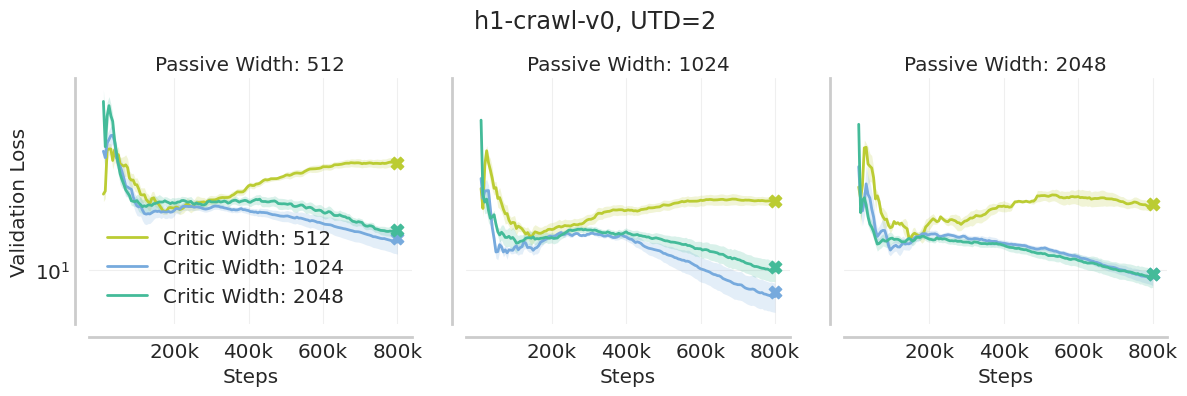

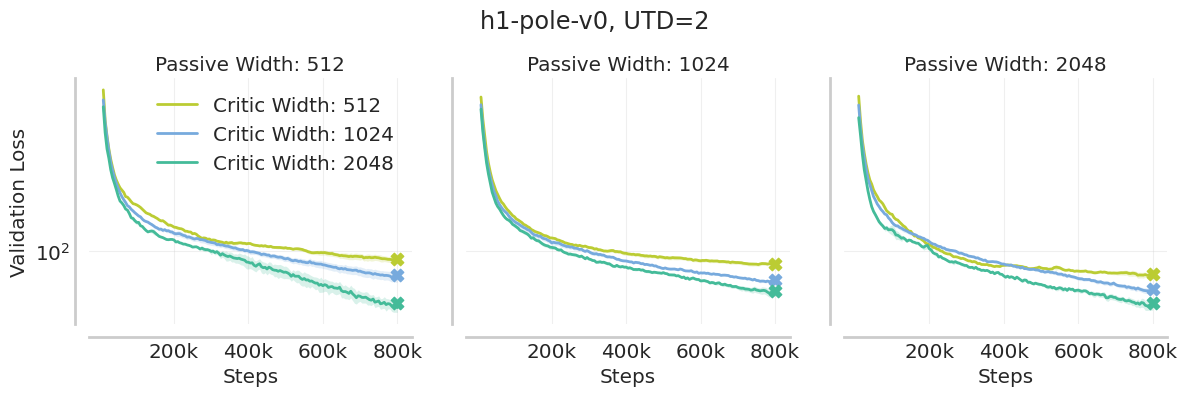

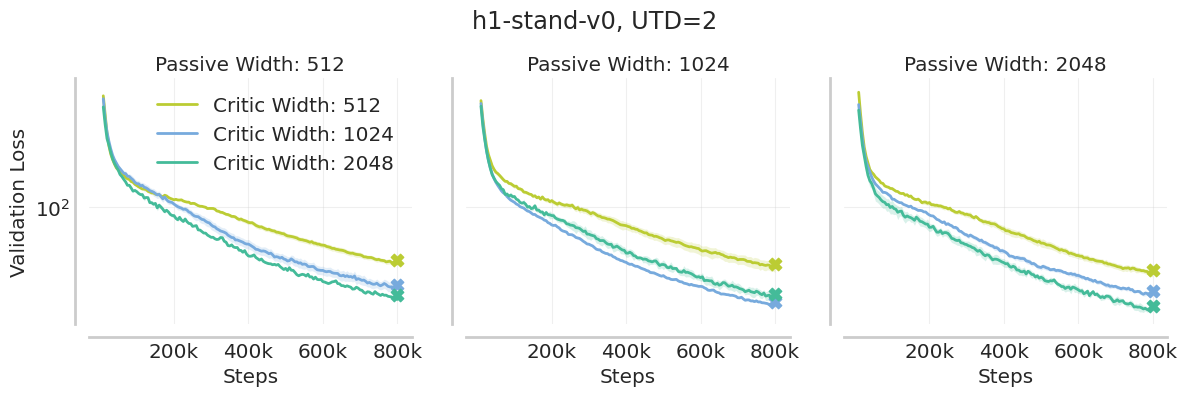

In [8]:
for i, ENV in enumerate(envs):
    fig, all_axes = plt.subplots(1, 3, figsize=(12, 4), sharey='row')

    axes = all_axes
    env_df = df.query(f'env_name == "{ENV}"')
    data = get_full_learning_curve_data(env_df)

    all_critic_widths = sorted(data['critic_width'].unique())
    all_separate_critic_widths = sorted(data['separate_critic_width'].unique())
    start_step = 10000

    colors = [COLORS[0], COLORS[1], COLORS[2]]

    for idx, separate_critic_width in enumerate(all_separate_critic_widths):
        ax = axes[idx]
        for jdx, critic_width in enumerate(all_critic_widths):
            subset = data.query(
                f'critic_width == {critic_width} and separate_critic_width == {separate_critic_width}'
            )

            if not subset.empty:
                # Get the actual loss curves (not summarized)
                training_curve = subset['mean_separate_critic_loss'].iloc[0]
                training_curve_std = subset['std_separate_critic_loss'].iloc[0]
                validation_curve = subset['mean_sep_validation_critic_loss'].iloc[0]
                validation_curve_std = subset['std_sep_validation_critic_loss'].iloc[0]

                steps = subset['training_step'].iloc[0]
                step_idx = steps >= start_step
                avg_idx = (steps >= start_step_for_avg) & (steps <= end_step_for_avg)

                # plot validation loss
                color = colors[jdx]
                val_lines = ax.plot(
                    steps[step_idx],
                    validation_curve[step_idx],
                    color=color,
                    linewidth=2,
                    label=f'Critic Width: {critic_width}',
                )

                ax.scatter(
                    steps.max(),
                    validation_curve[avg_idx].mean(),
                    color=color,
                    marker='X',
                    s=80,
                    zorder=100,
                )
                ax.fill_between(
                    steps[step_idx],
                    validation_curve[step_idx] - validation_curve_std[step_idx],
                    validation_curve[step_idx] + validation_curve_std[step_idx],
                    color=color,
                    alpha=0.2,
                    linewidth=0,
                )

        ax.set_yscale('log')  # Use log scale for better visualization

        # style
        ax.xaxis.set_minor_locator(plt.NullLocator())
        ax.set_title(f'Passive Width: {separate_critic_width}', fontsize='x-large')

        rliable_plot_utils._annotate_and_decorate_axis(
            ax,
            xlabel='Steps',
            ylabel='Validation Loss' if idx == 0 else None,
            labelsize='x-large',
            ticklabelsize='x-large',
            grid_alpha=0.3,
            legend=False,
        )

        offset_text = ax.xaxis.get_offset_text()
        offset_text.set_text('x' + offset_text.get_text())  # prepend 'x'
        offset_text.set_color('gray')
        offset_text.set_fontsize('x-large')

        ax.set_xticks([200000, 400000, 600000, 800000])
        ax.set_xticklabels(['200k', '400k', '600k', '800k'])

    # add legend to first subplot
    axes[0].legend(fontsize='x-large', frameon=False)

    fig.suptitle(f'{ENV}, UTD=2', fontsize='xx-large')

    # show plot
    plt.tight_layout(w_pad=3)
    plt.show()

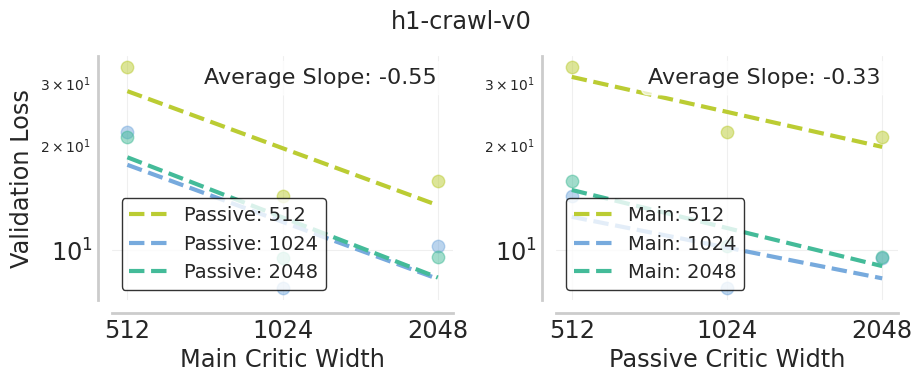

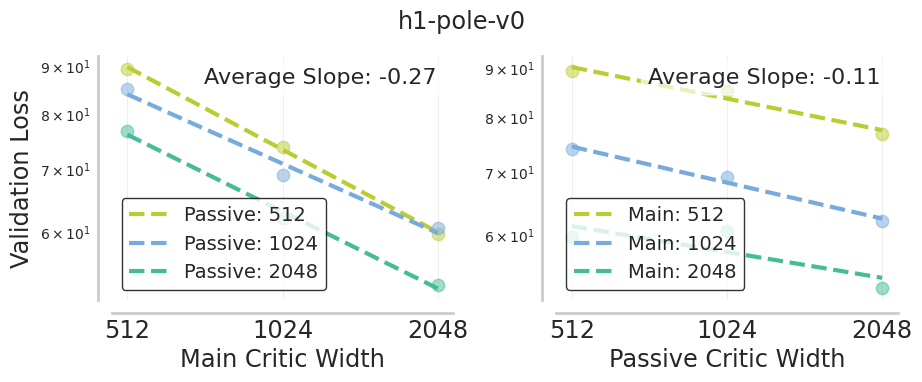

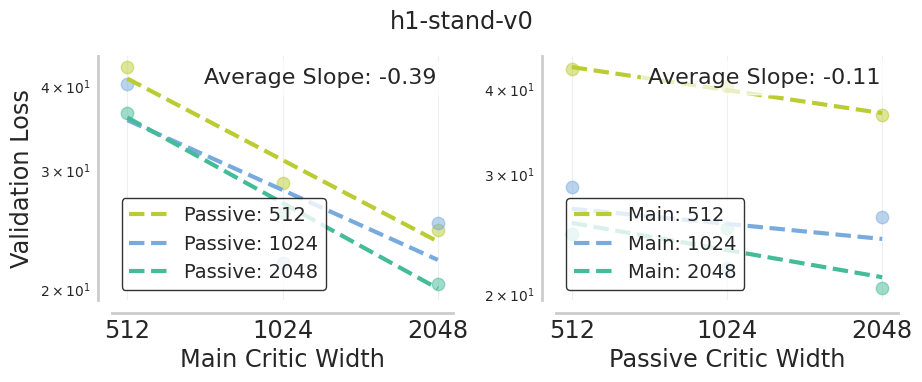

In [9]:
import statsmodels.api as sm
# getting the data


# Helper function to calculate the summary metric for a single row
# Essentially take the mean of a row from start_step to end_step
def _calculate_summary_metric_for_row(
    row, training_step_col_name, metric_values_col_name, start_step, end_step
):
    try:
        steps = np.asarray(row[training_step_col_name])
        metric_values = np.asarray(row[metric_values_col_name])
    except Exception:
        return np.nan

    if steps.ndim == 0 or metric_values.ndim == 0 or steps.size == 0 or metric_values.size == 0:
        return np.nan

    if steps.size != metric_values.size:
        return np.nan

    mask = (steps >= start_step) & (steps <= end_step)
    relevant_metric_values = metric_values[mask]

    if relevant_metric_values.size > 0:
        return np.nanmean(relevant_metric_values)
    else:
        return np.nan


def get_data(og_df):
    df = og_df.copy()

    # Prepare data for both metrics
    all_data = []
    metric_col_name = 'mean_sep_validation_critic_loss'
    std_col_name = 'std_sep_validation_critic_loss'

    df_copy = df.copy()
    df_copy['summary_metric'] = df_copy.apply(
        lambda row: _calculate_summary_metric_for_row(
            row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
        ),
        axis=1,
    )
    # print(df_copy)
    # df_processed = df_copy.dropna(subset=['summary_metric'])
    df_processed = df_copy

    if df_processed.empty:
        print(
            f'Warning: No data found or processed for {metric_col_name} in the step range {start_step_for_avg}-{end_step_for_avg}.'
        )
        return

    identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
    df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)['summary_metric'].mean()
    df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
    df_plot_ready['separate_critic_width'] = pd.to_numeric(df_plot_ready['separate_critic_width'])

    return df_plot_ready


ENV = OLD_ENV = 'h1-pole-v0'
# getting the data

# colors

COLORS = [
    '#BBCC33',
    '#77AADD',
    '#44BB99',
    '#EEDD88',
    '#EE8866',
    '#FFAABB',
    '#99DDFF',
    '#44BB99',
    '#AAAA00',
    '#DDDDDD',
]
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{sansmath} \sansmath'  # Force sans-serif math mode (for axes labels)
)
plt.rcParams['font.family'] = 'sans-serif'  # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue']  # Choose a nice font here
sns.set_style('whitegrid')

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
n_colors = 3
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]


def make_slope_plot(envs):
    fig, all_axes = plt.subplots(len(envs), 2)
    all_axes = np.array(all_axes).reshape(-1, 2)
    fig.set_size_inches(896.0 / 192 * 2, 369.6 / 192 * 2 * len(envs))

    for i, ENV in enumerate(envs):
        axes = all_axes[i]
        env_df = df.query(f'env_name == "{ENV}"')
        data = get_data(env_df)

        all_critic_widths = sorted(data['critic_width'].unique())
        all_separate_critic_widths = sorted(data['separate_critic_width'].unique())

        slopes = []

        # ax[0] stuff
        # x-axis is the main critic width
        for i, separate_critic_width in enumerate(all_separate_critic_widths):
            x_values = []
            y_values = []

            for j, critic_width in enumerate(all_critic_widths):
                value = data[
                    (data['critic_width'] == critic_width)
                    & (data['separate_critic_width'] == separate_critic_width)
                ]['summary_metric'].values[0]
                axes[0].scatter(critic_width, value, marker='o', color=COLORS[i], alpha=0.5, s=80)
                x_values.append(critic_width)
                y_values.append(value)

            # ax[0] plot the fitted line
            smooth_x = np.log(x_values)
            smooth_y = np.log(y_values)
            linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
            y_fit = linear_fit.predict(sm.add_constant(smooth_x))
            intercept, slope = linear_fit.params
            slopes.append(slope)
            axes[0].plot(
                np.exp(smooth_x),
                np.exp(y_fit),
                '--',
                color=COLORS[i],
                alpha=1.0,
                label=f'Passive: {separate_critic_width}',
                linewidth=3,
            )

        axes[0].text(
            0.95,
            0.95,
            f'Average Slope: {round(np.mean(slopes), 2)}',
            transform=axes[0].transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
            fontsize=16,
        )

        axes[0].set_xscale('log')
        axes[0].set_yscale('log')
        axes[0].legend(
            prop={'size': 14},
            ncol=1,
            frameon=True,
            loc='lower left',
            facecolor='white',
            edgecolor='black',
        )

        x = np.logspace(np.log10(512), np.log10(2048), num=3)
        x_ticks_labels = [f'{int(x)}' for x in x]
        axes[0].xaxis.set_major_locator(plt.FixedLocator(x))
        axes[0].xaxis.set_minor_locator(plt.NullLocator())
        axes[0].set_xticks(x, x_ticks_labels)

        plot_utils._annotate_and_decorate_axis(
            axes[0],
            xlabel='Main Critic Width',
            ylabel='Validation Loss',
            labelsize='xx-large',
            ticklabelsize='xx-large',
            grid_alpha=0.3,
            legend=False,
        )

        slopes = []

        # ax[1] stuff
        for i, critic_width in enumerate(all_critic_widths):
            x_values = []
            y_values = []

            for j, separate_critic_width in enumerate(all_separate_critic_widths):
                value = data[
                    (data['critic_width'] == critic_width)
                    & (data['separate_critic_width'] == separate_critic_width)
                ]['summary_metric'].values[0]
                axes[1].scatter(
                    separate_critic_width, value, marker='o', color=COLORS[i], alpha=0.5, s=80
                )
                x_values.append(separate_critic_width)
                y_values.append(value)

            # ax[1] plot the fitted line
            smooth_x = np.log(x_values)
            smooth_y = np.log(y_values)
            linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
            y_fit = linear_fit.predict(sm.add_constant(smooth_x))
            intercept, slope = linear_fit.params
            slopes.append(slope)
            axes[1].plot(
                np.exp(smooth_x),
                np.exp(y_fit),
                '--',
                color=COLORS[i],
                alpha=1.0,
                label=f'Main: {critic_width}',
                linewidth=3,
            )

        axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        axes[1].legend(
            prop={'size': 14},
            ncol=1,
            frameon=True,
            loc='lower left',
            facecolor='white',
            edgecolor='black',
        )
        axes[1].text(
            0.95,
            0.95,
            f'Average Slope: {round(np.mean(slopes), 2)}',
            transform=axes[1].transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
            fontsize=16,
        )

        x = np.logspace(np.log10(512), np.log10(2048), num=3)
        x_ticks_labels = [f'{int(x)}' for x in x]
        axes[1].xaxis.set_major_locator(plt.FixedLocator(x))
        axes[1].xaxis.set_minor_locator(plt.NullLocator())
        axes[1].set_xticks(x, x_ticks_labels)

        plot_utils._annotate_and_decorate_axis(
            axes[1],
            xlabel='Passive Critic Width',
            # ylabel='Validation Loss',
            labelsize='xx-large',
            ticklabelsize='xx-large',
            grid_alpha=0.3,
            legend=False,
        )

        # axes[0].set_title(ENV, fontsize='xx-large')
        # axes[1].set_title(ENV, fontsize='xx-large')
    fig.suptitle(ENV, fontsize='xx-large')

    plt.tight_layout(h_pad=3)
    plt.show()


for env in envs:
    make_slope_plot([env])